# 📊 Analyse de Corrélation Dynamique des Cryptomonnaies

## 🎯 Objectif du Projet

Ce notebook présente une **analyse complète des corrélations dynamiques** entre cryptomonnaies majeures pour :
- 📈 **Identifier des groupes** d'actifs avec comportements similaires
- 🔄 **Analyser l'évolution temporelle** des corrélations sur 2 ans
- 🎪 **Détecter les changements de régime** dans les marchés crypto
- 🎯 **Fournir des insights** pour l'optimisation de portefeuille

## 📋 Structure du Notebook
1. Configuration et imports
2. Collecte des données
3. Prétraitement des données
4. Analyse de corrélation dynamique
5. Clustering hiérarchique
6. Visualisation en réseau des corrélations
7. Clustering temporel avec K-Means
8. Détection automatique des changements de régime
9. Clustering spectral optimisé
10. Rapport final et conclusion

In [10]:
# ================================================================================================
# 📦 1. CONFIGURATION ET IMPORTS
# ================================================================================================

# Suppression des warnings pour une sortie plus propre
import warnings
warnings.filterwarnings('ignore')

# === IMPORTS PRINCIPAUX ===
import datetime
import pandas as pd
import numpy as np

# === VISUALISATION ===
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# === DONNÉES FINANCIÈRES ===
import yfinance as yf

# === MACHINE LEARNING & CLUSTERING ===
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score

# === ANALYSE STATISTIQUE ===
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler


# === ANALYSE DE RÉSEAUX ===
import networkx as nx
from itertools import combinations

# === CONFIGURATION GRAPHIQUES ===
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 11,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white'
})

print("✅ Tous les modules importés avec succès")
print(f"📅 Date d'exécution : {datetime.datetime.now().strftime('%d/%m/%Y %H:%M')}")

✅ Tous les modules importés avec succès
📅 Date d'exécution : 30/05/2025 15:44


# 📦 2. COLLECTE DES DONNÉES

Téléchargement des données historiques sur **2 ans** pour les 9 cryptomonnaies sélectionnées:

| Crypto | Symbole | Description |
|--------|---------|-------------|
| **Ethereum** | ETH-USD | Plateforme smart contracts |
| **Binance Coin** | BNB-USD | Token exchange Binance |
| **Ripple** | XRP-USD | Réseau de paiements |
| **Solana** | SOL-USD | Blockchain haute performance |
| **Cardano** | ADA-USD | Blockchain académique |
| **Polkadot** | DOT-USD | Interopérabilité blockchain |
| **Shiba Inu** | SHIB-USD | Meme coin populaire |
| **Litecoin** | LTC-USD | "L'argent numérique" |
| **Avalanche** | AVAX-USD | Plateforme DeFi |

In [4]:
def collect_crypto_data(symbols, num_days=730):
    """
    Collecte les données historiques des cryptomonnaies
    
    Args:
        symbols: Liste des symboles de cryptomonnaies
        num_days: Nombre de jours d'historique (défaut: 730 = 2 ans)
    
    Returns:
        DataFrame avec les prix de clôture quotidiens
    """
    print("📈 Collecte des données en cours...")
    
    # Configuration des dates
    start = datetime.date.today() - datetime.timedelta(days=num_days)
    end = datetime.date.today()
    
    print(f"📅 Période : {start} → {end} ({num_days} jours)")
    
    # Téléchargement des données
    data_close = pd.DataFrame()
    success_count = 0
    
    for i, symbol in enumerate(symbols, 1):
        try:
            print(f"   [{i:2d}/{len(symbols)}] {symbol:<10} ... ", end="")
            data = yf.download(symbol, start=start, end=end, interval="1d", progress=False)
            
            if not data.empty:
                data_close[symbol] = data["Close"]
                success_count += 1
                print("✅")
            else:
                print("❌ (Données vides)")
                
        except Exception as e:
            print(f"❌ ({str(e)[:30]}...)")
    
    # Nettoyage des données
    initial_length = len(data_close)
    data_close.dropna(inplace=True)
    final_length = len(data_close)
    
    print(f"\n📊 Résumé :")
    print(f"   • Cryptos collectées : {success_count}/{len(symbols)}")
    print(f"   • Données brutes : {initial_length:,} jours")
    print(f"   • Données nettoyées : {final_length:,} jours")
    print(f"   • Données supprimées : {initial_length - final_length:,} jours")
    
    return data_close

# === CONFIGURATION DES CRYPTOMONNAIES ===
crypto_symbols = [
    "ETH-USD",   # Ethereum
    "BNB-USD",   # Binance Coin
    "XRP-USD",   # Ripple
    "SOL-USD",   # Solana
    "ADA-USD",   # Cardano
    "DOT-USD",   # Polkadot
    "SHIB-USD",  # Shiba Inu
    "LTC-USD",   # Litecoin
    "AVAX-USD"   # Avalanche
]

# === COLLECTE DES DONNÉES ===
data_close = collect_crypto_data(crypto_symbols, num_days=730)

# Aperçu des données
print(f"\n📋 Aperçu des données collectées :")
print(data_close.tail())
print(f"\n📏 Dimensions finales : {data_close.shape}")

📈 Collecte des données en cours...
📅 Période : 2023-05-31 → 2025-05-30 (730 jours)
   [ 1/9] ETH-USD    ... YF.download() has changed argument auto_adjust default to True
✅
✅  [ 2/9] BNB-USD    ... 
✅  [ 3/9] XRP-USD    ... 
✅  [ 4/9] SOL-USD    ... 
✅  [ 5/9] ADA-USD    ... 
✅  [ 6/9] DOT-USD    ... 
✅  [ 7/9] SHIB-USD   ... 
✅  [ 8/9] LTC-USD    ... 
✅  [ 9/9] AVAX-USD   ... 

📊 Résumé :
   • Cryptos collectées : 9/9
   • Données brutes : 730 jours
   • Données nettoyées : 730 jours
   • Données supprimées : 0 jours

📋 Aperçu des données collectées :
                ETH-USD     BNB-USD   XRP-USD     SOL-USD   ADA-USD   DOT-USD  \
Date                                                                            
2025-05-25  2551.763916  669.916870  2.342975  175.725479  0.759983  4.525113   
2025-05-26  2564.138428  674.392639  2.310661  174.907898  0.759555  4.468652   
2025-05-27  2663.069824  687.159485  2.318672  176.815186  0.758683  4.537437   
2025-05-28  2682.212891  687.405518 

# 🧮 3. PRÉTRAITEMENT DES DONNÉES

Calcul des rendements logarithmiques pour normaliser les données et faciliter l'analyse statistique.
Permet également de stabiliser la variance et de réduire l'asymétrie des distributions.

🔢 Calcul des rendements logarithmiques...
Rendements calculés pour 729 jours

📈 Statistiques des rendements normalisés:
Rendement moyen : -0.0000
Volatilité moyenne : 1.0007


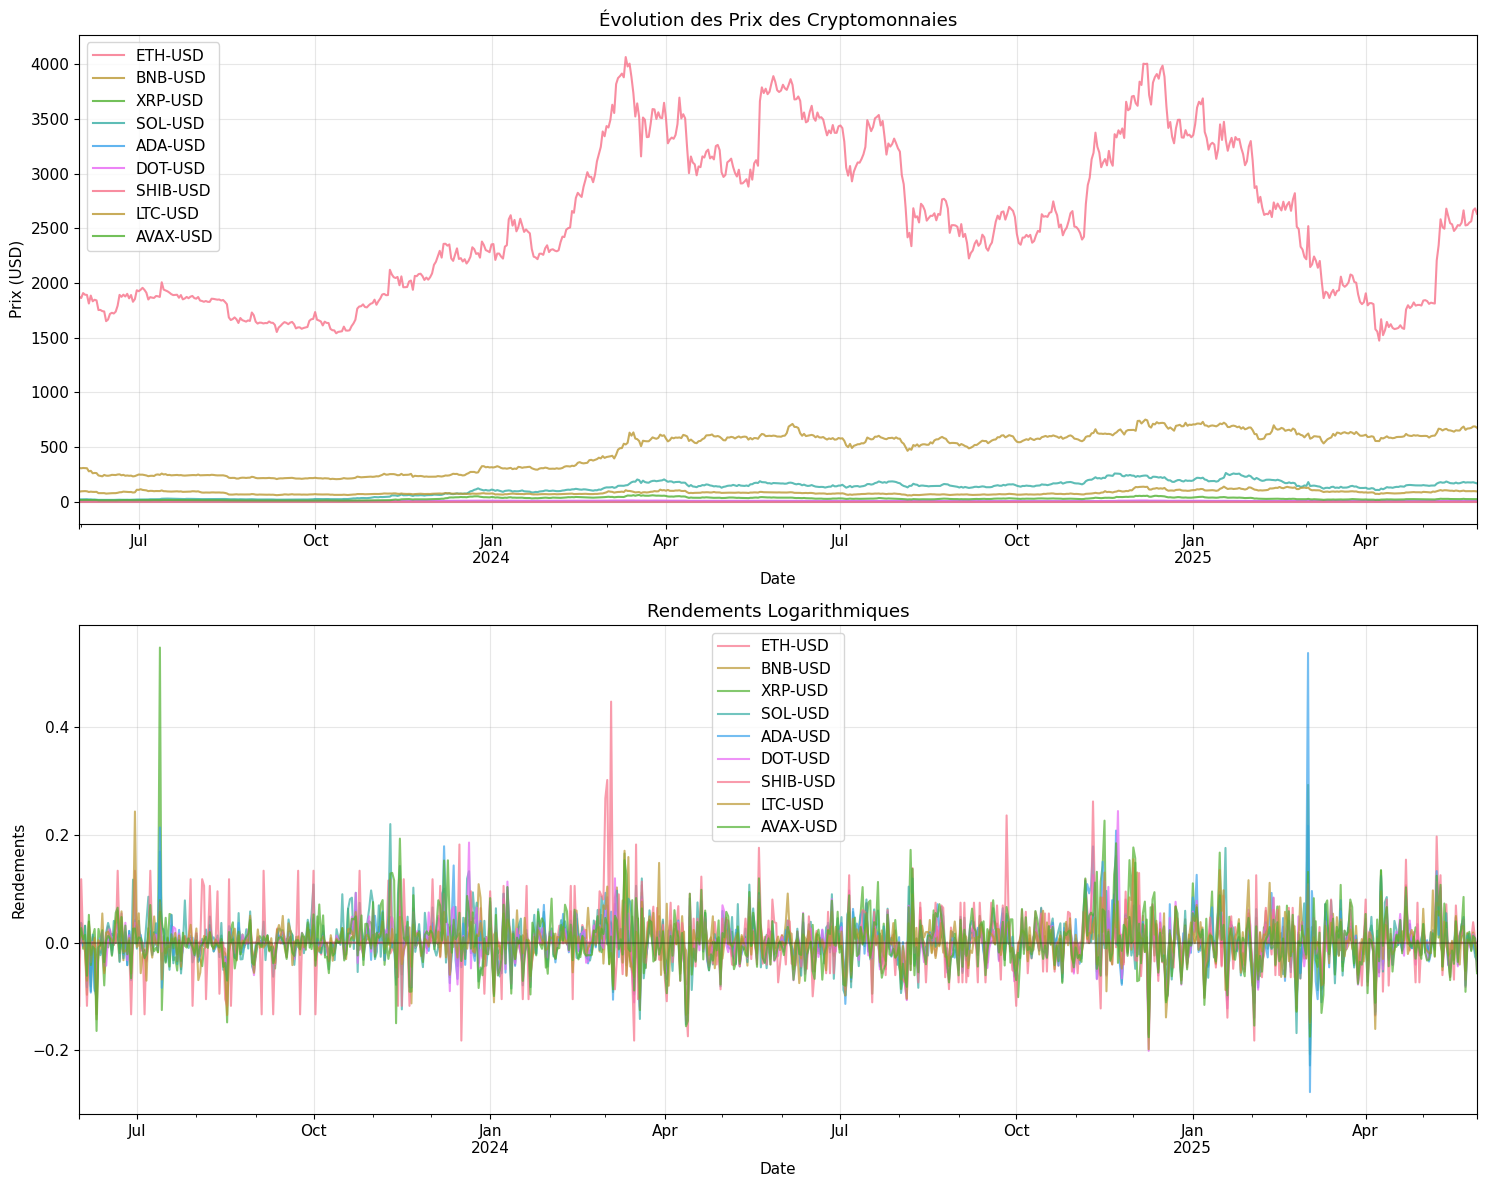

✅ Prétraitement des données terminé


In [8]:
def calculate_log_returns(price_data):
    """
    Calcule les rendements logarithmiques à partir des prix
    
    Args:
        price_data: DataFrame avec les prix de clôture
    
    Returns:
        DataFrame avec les rendements logarithmiques
    """
    print("🔢 Calcul des rendements logarithmiques...")
    
    # Calcul des rendements logarithmiques
    log_returns = np.log(price_data / price_data.shift(1))
    log_returns.dropna(inplace=True)
    
    print(f"Rendements calculés pour {len(log_returns)} jours")

    # Normalisation (centrage-réduction)
    scaler = StandardScaler()
    log_returns_normalized = pd.DataFrame(
        scaler.fit_transform(log_returns),
        index=log_returns.index,
        columns=log_returns.columns
    )
    
    # Statistiques descriptives
    print("\n📈 Statistiques des rendements normalisés:")
    print(f"Rendement moyen : {log_returns_normalized.mean().mean():.4f}")
    print(f"Volatilité moyenne : {log_returns_normalized.std().mean():.4f}")
    
    return log_returns

# Calcul des rendements
log_returns = calculate_log_returns(data_close)

# Visualisation des rendements
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Graphique des prix
data_close.plot(ax=axes[0], title="Évolution des Prix des Cryptomonnaies", 
                legend=True, alpha=0.8)
axes[0].set_ylabel("Prix (USD)")
axes[0].grid(True, alpha=0.3)

# Graphique des rendements
log_returns.plot(ax=axes[1], title="Rendements Logarithmiques", 
                 legend=True, alpha=0.7)
axes[1].set_ylabel("Rendements")
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Prétraitement des données terminé")

# 📊 4. ANALYSE DE CORRÉLATION DYNAMIQUE

Calcul des matrices de corrélation glissantes avec une fenêtre de 30 jours pour capturer l'évolution 
temporelle des relations entre cryptomonnaies.

In [8]:
def calculate_rolling_correlations(returns_data, window=30):
    """
    Calcule les corrélations glissantes pour analyser l'évolution temporelle
    
    Args:
        returns_data: DataFrame des rendements
        window: Taille de la fenêtre glissante (jours)
    
    Returns:
        Liste des matrices de corrélation, dates correspondantes
    """
    print(f"🔄 Calcul des corrélations glissantes (fenêtre: {window} jours)...")
    
    rolling_corrs = []
    
    # Calcul des corrélations glissantes avec barre de progression
    for i in range(window, len(returns_data) + 1):
        if i % 50 == 0:  # Affichage du progrès
            progress = (i - window + 1) / (len(returns_data) - window + 1) * 100
            print(f"  Progression: {progress:.1f}%")
        
        corr_matrix = returns_data.iloc[i-window:i].corr()
        rolling_corrs.append(corr_matrix)
    
    # Dates correspondantes
    dates = returns_data.index[window-1:]
    
    print(f"✅ {len(rolling_corrs)} matrices de corrélation calculées")
    print(f"Période couverte: {dates[0].date()} à {dates[-1].date()}")
    
    return rolling_corrs, dates

# Calcul des corrélations glissantes
window_size = 30
rolling_correlations, correlation_dates = calculate_rolling_correlations(log_returns, window_size)

# Sauvegarde des données pour usage ultérieur
latest_correlation = rolling_correlations[-1]
latest_correlation.to_csv('last_correlation_matrix.csv')
print(f"\n💾 Dernière matrice de corrélation sauvegardée: last_correlation_matrix.csv")

🔄 Calcul des corrélations glissantes (fenêtre: 30 jours)...
  Progression: 3.0%
  Progression: 10.1%
  Progression: 17.3%
  Progression: 24.4%
  Progression: 31.6%
  Progression: 38.7%
  Progression: 45.9%
  Progression: 53.0%
  Progression: 60.1%
  Progression: 67.3%
  Progression: 74.4%
  Progression: 81.6%
  Progression: 88.7%
  Progression: 95.9%
✅ 700 matrices de corrélation calculées
Période couverte: 2023-06-30 à 2025-05-29

💾 Dernière matrice de corrélation sauvegardée: last_correlation_matrix.csv


🚀 Analyse de corrélations avec vos données crypto
🔍 Diagnostic initial des données:
Forme des données: (729, 9)
Colonnes: ['ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'DOT-USD', 'SHIB-USD', 'LTC-USD', 'AVAX-USD']
Période: 2023-06-01 à 2025-05-29
Valeurs manquantes par colonne:
ETH-USD     0
BNB-USD     0
XRP-USD     0
SOL-USD     0
ADA-USD     0
DOT-USD     0
SHIB-USD    0
LTC-USD     0
AVAX-USD    0
dtype: int64

Statistiques descriptives:
          ETH-USD     BNB-USD     XRP-USD     SOL-USD     ADA-USD     DOT-USD  \
count  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000   
mean     0.000466    0.001082    0.002013    0.002852    0.000901   -0.000278   
std      0.033355    0.027552    0.045926    0.046573    0.047380    0.040791   
min     -0.160731   -0.113212   -0.207859   -0.228588   -0.278123   -0.201399   
25%     -0.014332   -0.011390   -0.014423   -0.025042   -0.021550   -0.021928   
50%      0.000347    0.000945    0.000240   -0.000266    0

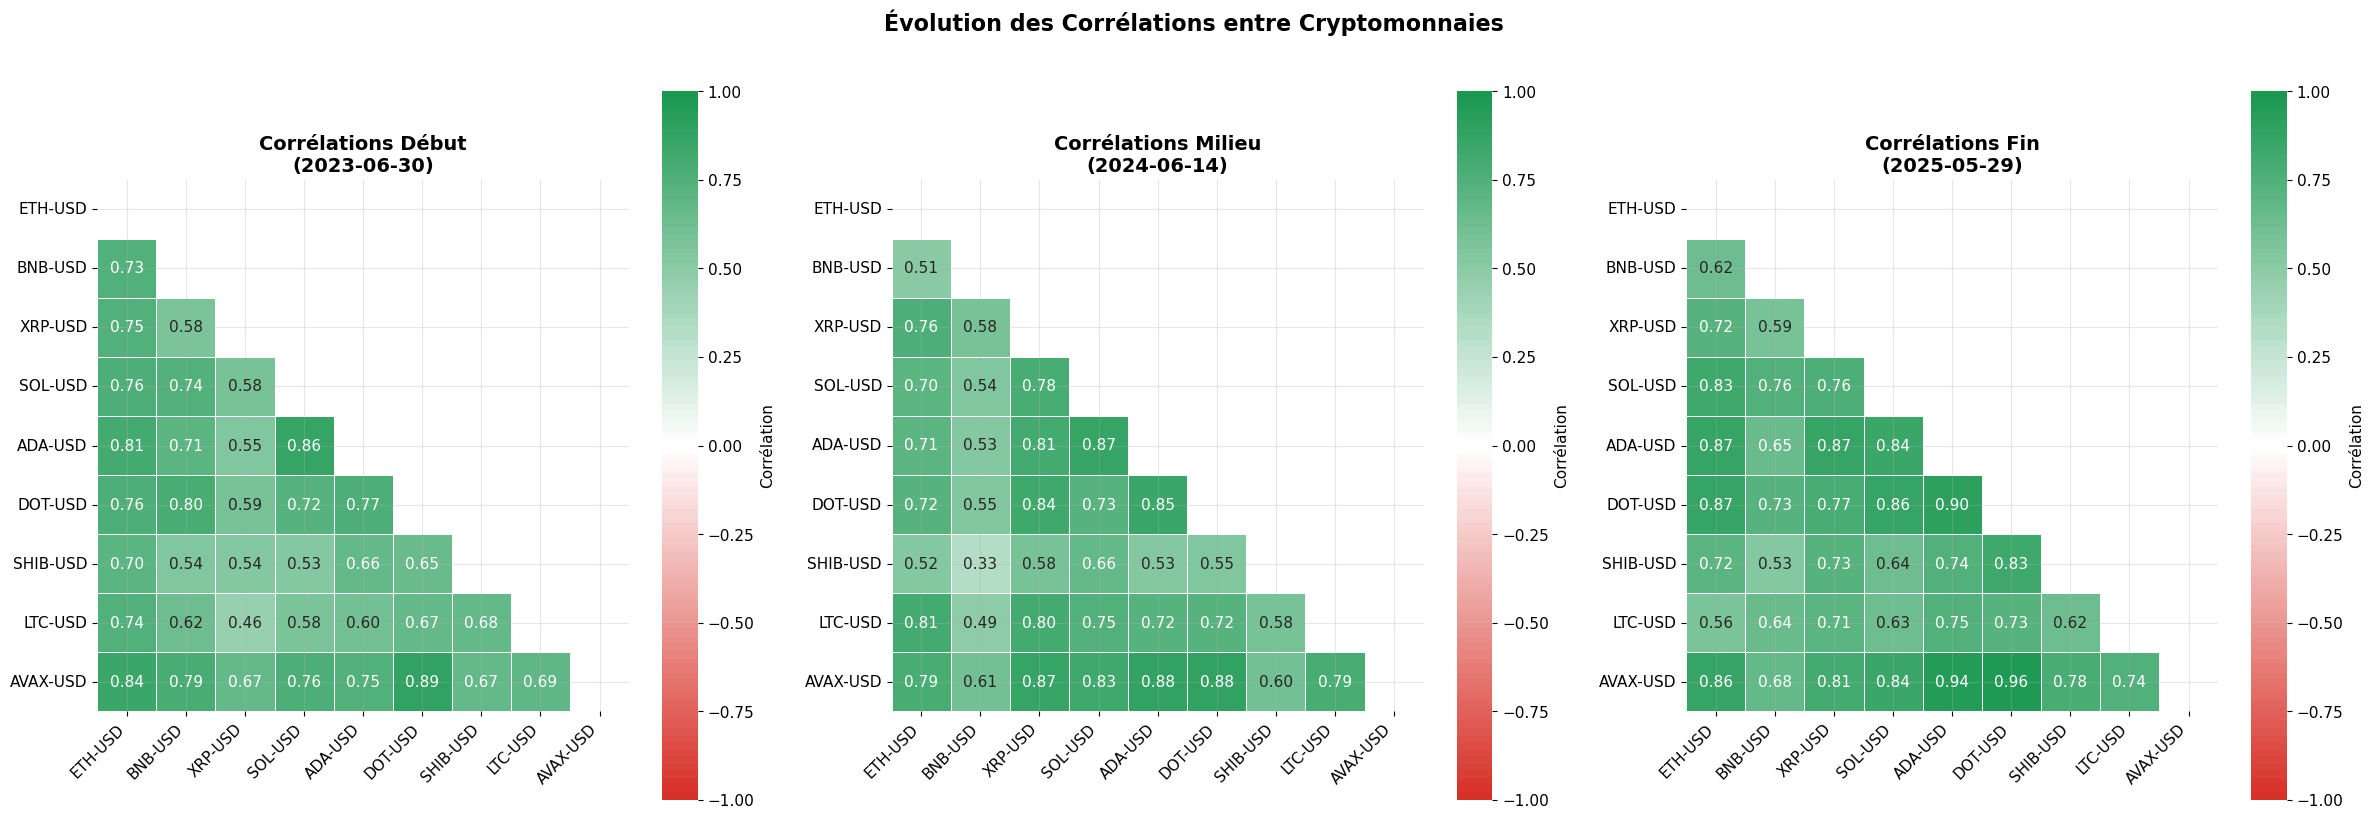

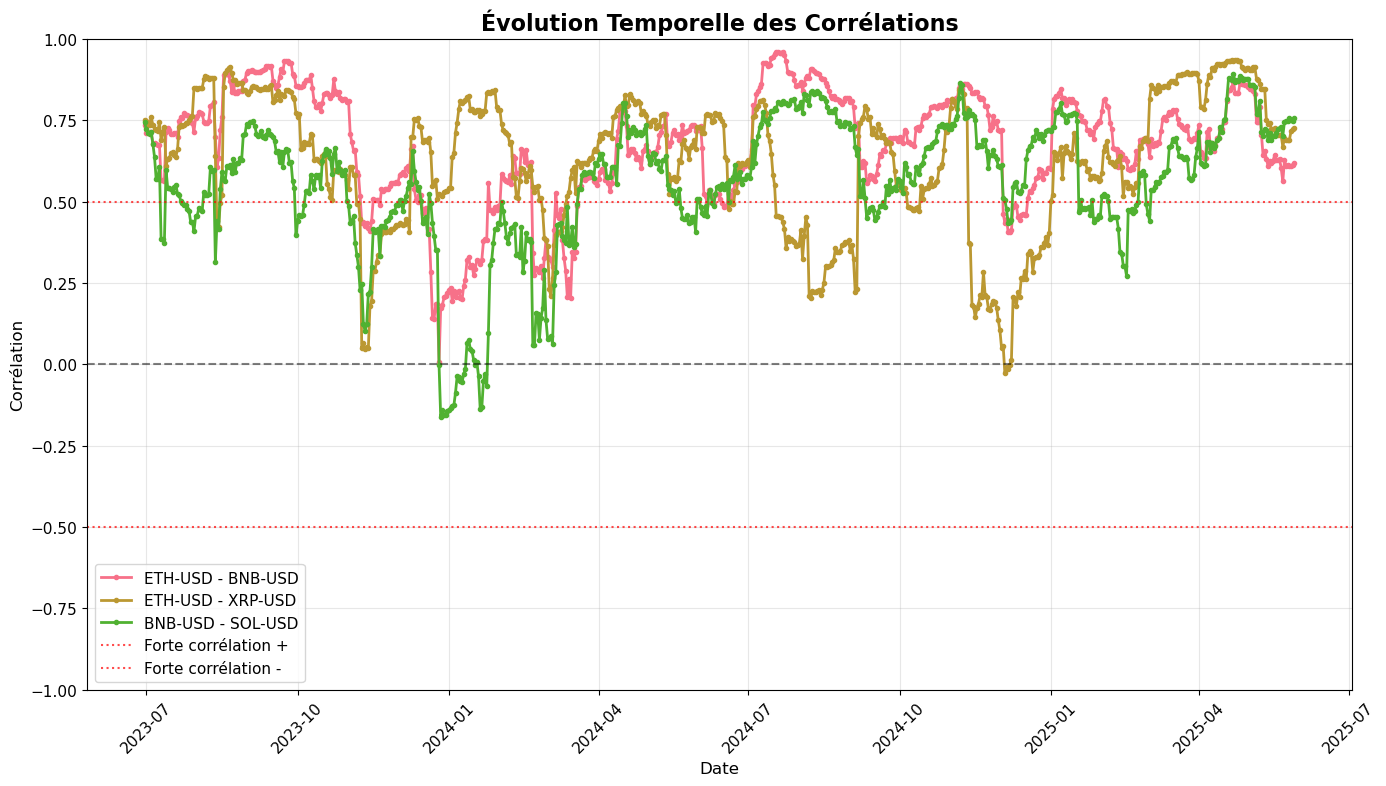

✅ Analyse terminée avec succès!


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

def validate_data(returns_data):
    """
    Valide et nettoie les données de rendements
    
    Args:
        returns_data: DataFrame des rendements
    
    Returns:
        DataFrame nettoyé ou None si problème critique
    """
    print("🔍 Validation des données...")
    
    # Vérifications de base
    if returns_data.empty:
        print("❌ Erreur: DataFrame vide")
        return None
    
    if returns_data.isnull().all().all():
        print("❌ Erreur: Toutes les valeurs sont NaN")
        return None
    
    # Statistiques sur les données manquantes
    missing_pct = (returns_data.isnull().sum() / len(returns_data)) * 100
    print(f"📊 Données manquantes par colonne:")
    for col, pct in missing_pct.items():
        if pct > 0:
            print(f"  {col}: {pct:.1f}%")
        else:
            print(f"  {col}: ✅ Aucune")
    
    # Statistiques descriptives
    print(f"\n📈 Statistiques des rendements:")
    print(f"  Période: {returns_data.index[0].date()} à {returns_data.index[-1].date()}")
    print(f"  Observations: {len(returns_data)}")
    print(f"  Cryptomonnaies: {list(returns_data.columns)}")
    
    # Vérifier la variance (éviter les séries constantes)
    zero_variance = returns_data.var() == 0
    if zero_variance.any():
        print(f"⚠️  Attention: Variance nulle détectée pour {zero_variance[zero_variance].index.tolist()}")
    
    # Nettoyer les données
    clean_data = returns_data.dropna()
    if len(clean_data) < len(returns_data) * 0.8:
        print(f"⚠️  Attention: {len(returns_data) - len(clean_data)} lignes supprimées (beaucoup de NaN)")
    
    print(f"✅ Données validées: {len(clean_data)} observations utilisables")
    return clean_data

def calculate_rolling_correlations(returns_data, window=30):
    """
    Calcule les corrélations glissantes pour analyser l'évolution temporelle
    
    Args:
        returns_data: DataFrame des rendements
        window: Taille de la fenêtre glissante (jours)
    
    Returns:
        Liste des matrices de corrélation, dates correspondantes
    """
    print(f"🔄 Calcul des corrélations glissantes (fenêtre: {window} jours)...")
    
    # Validation des données
    clean_data = validate_data(returns_data)
    if clean_data is None:
        return None, None
    
    if window > len(clean_data):
        print(f"❌ Erreur: Fenêtre ({window}) > données disponibles ({len(clean_data)})")
        return None, None
    
    rolling_corrs = []
    dates = []
    
    for i in range(window, len(clean_data) + 1):
        if i % 50 == 0 or i == window:
            progress = (i - window + 1) / (len(clean_data) - window + 1) * 100
            print(f"  Progression: {progress:.1f}%")
        
        # Calculer la corrélation pour la fenêtre actuelle
        window_data = clean_data.iloc[i-window:i]
        corr_matrix = window_data.corr()
        
        # Vérifier que la matrice n'est pas vide
        if not corr_matrix.isnull().all().all():
            rolling_corrs.append(corr_matrix)
            dates.append(clean_data.index[i-1])
    
    if not rolling_corrs:
        print("❌ Erreur: Aucune matrice de corrélation valide calculée")
        return None, None
    
    print(f"✅ {len(rolling_corrs)} matrices de corrélation calculées")
    print(f"Période couverte: {dates[0].date()} à {dates[-1].date()}")
    
    return rolling_corrs, dates

def visualize_correlation_snapshots(rolling_corrs, dates):
    """
    Visualisation statique de la corrélation à 3 dates clés : début, milieu, fin
    
    Args:
        rolling_corrs: Liste des matrices de corrélation
        dates: Dates correspondantes
    """
    if not rolling_corrs or not dates:
        print("❌ Pas de données à visualiser")
        return
    
    print("📊 Création des visualisations statiques...")
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    indices = [0, len(rolling_corrs)//2, -1]
    labels = ["Début", "Milieu", "Fin"]
    
    # Créer une colormap personnalisée
    colors = ['#d73027', '#ffffff', '#1a9850']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    for i, (idx, label) in enumerate(zip(indices, labels)):
        corr_matrix = rolling_corrs[idx]
        date = dates[idx]
        
        # Masquer la diagonale pour une meilleure lisibilité
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        sns.heatmap(corr_matrix,
                    mask=mask,
                    annot=True,
                    cmap=cmap,
                    center=0,
                    vmin=-1,
                    vmax=1,
                    square=True,
                    fmt=".2f",
                    cbar_kws={'label': 'Corrélation'},
                    ax=axes[i],
                    linewidths=0.5)
        
        axes[i].set_title(f"Corrélations {label}\n({date.date()})", 
                         fontsize=14, fontweight='bold')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), 
                               rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), 
                               rotation=0)
    
    plt.suptitle("Évolution des Corrélations entre Cryptomonnaies", 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_correlation_evolution(rolling_corrs, dates, pairs=None):
    """
    Graphique de l'évolution temporelle des corrélations entre paires spécifiques
    
    Args:
        rolling_corrs: Liste des matrices de corrélation
        dates: Dates correspondantes
        pairs: Liste de tuples (crypto1, crypto2) à analyser
    """
    if not rolling_corrs or not dates:
        print("❌ Pas de données à visualiser")
        return
    
    # Si pas de paires spécifiées, prendre les plus intéressantes
    if pairs is None:
        coins = rolling_corrs[0].columns.tolist()
        pairs = [(coins[0], coins[1]), (coins[0], coins[2])] if len(coins) >= 3 else [(coins[0], coins[1])]
    
    plt.figure(figsize=(14, 8))
    
    for pair in pairs:
        correlations = []
        valid_dates = []
        
        for corr_matrix, date in zip(rolling_corrs, dates):
            if pair[0] in corr_matrix.columns and pair[1] in corr_matrix.columns:
                corr_val = corr_matrix.loc[pair[0], pair[1]]
                if not pd.isna(corr_val):
                    correlations.append(corr_val)
                    valid_dates.append(date)
        
        if correlations:
            plt.plot(valid_dates, correlations, 
                    label=f"{pair[0]} - {pair[1]}", 
                    linewidth=2, marker='o', markersize=3)
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, label='Forte corrélation +')
    plt.axhline(y=-0.5, color='red', linestyle=':', alpha=0.7, label='Forte corrélation -')
    
    plt.title("Évolution Temporelle des Corrélations", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Corrélation", fontsize=12)
    plt.ylim(-1, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def animate_correlation(rolling_corrs, dates, save_path=None):
    """
    Animation de l'évolution des matrices de corrélation dans le temps
    
    Args:
        rolling_corrs: Liste des matrices de corrélation
        dates: Dates correspondantes
        save_path: Chemin pour sauvegarder l'animation (optionnel)
    """
    if not rolling_corrs or not dates:
        print("❌ Pas de données à animer")
        return None
    
    print("🎬 Création de l'animation...")
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Créer une colormap personnalisée
    colors = ['#d73027', '#ffffff', '#1a9850']
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=100)
    
    def update(frame):
        ax.clear()
        
        # Masquer la diagonale supérieure
        mask = np.triu(np.ones_like(rolling_corrs[frame], dtype=bool))
        
        sns.heatmap(rolling_corrs[frame],
                    mask=mask,
                    annot=True,
                    cmap=cmap,
                    center=0,
                    vmin=-1,
                    vmax=1,
                    square=True,
                    fmt='.2f',
                    cbar=True,
                    ax=ax,
                    linewidths=0.5)
        
        ax.set_title(f"Matrice de Corrélation - {dates[frame].date()}", 
                    fontsize=14, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    anim = animation.FuncAnimation(fig, update, frames=len(rolling_corrs), 
                                 interval=500, repeat=True)
    
    if save_path:
        print(f"💾 Sauvegarde de l'animation vers {save_path}...")
        anim.save(save_path, writer='pillow', fps=2)
    
    plt.show()
    return anim

# INSTRUCTIONS D'UTILISATION:
# 1. Assurez-vous que votre variable 'log_returns' existe
# 2. Executez simplement le code ci-dessous
# 3. Si vous avez des erreurs, vérifiez le diagnostic initial

# UTILISATION DIRECTE AVEC VOS DONNÉES
print("🚀 Analyse de corrélations avec vos données crypto")

# Diagnostic initial des données
print("🔍 Diagnostic initial des données:")
print(f"Forme des données: {log_returns.shape}")
print(f"Colonnes: {log_returns.columns.tolist()}")
print(f"Période: {log_returns.index[0].date()} à {log_returns.index[-1].date()}")
print(f"Valeurs manquantes par colonne:")
print(log_returns.isnull().sum())
print(f"\nStatistiques descriptives:")
print(log_returns.describe())

# Calculer les corrélations glissantes avec vos données
window_size = 30
rolling_correlations, correlation_dates = calculate_rolling_correlations(log_returns, window_size)

if rolling_correlations is not None:
    # Visualisations avec vos données
    visualize_correlation_snapshots(rolling_correlations, correlation_dates)
    
    # Graphique d'évolution temporelle (adapter les paires selon vos cryptos)
    cryptos = log_returns.columns.tolist()
    if len(cryptos) >= 2:
        pairs_to_plot = [(cryptos[0], cryptos[1])]
        if len(cryptos) >= 3:
            pairs_to_plot.append((cryptos[0], cryptos[2]))
        if len(cryptos) >= 4:
            pairs_to_plot.append((cryptos[1], cryptos[3]))
        
        plot_correlation_evolution(rolling_correlations, correlation_dates, pairs_to_plot)
    
    # Animation (décommentez si vous voulez l'animation)
    # print("🎬 Création de l'animation...")
    # anim = animate_correlation(rolling_correlations, correlation_dates)
    
    print("✅ Analyse terminée avec succès!")
else:
    print("❌ Échec de l'analyse - vérifiez vos données")
    print("💡 Suggestions:")
    print("- Vérifiez que log_returns n'est pas vide")
    print("- Assurez-vous qu'il y a assez de données non-nulles")
    print("- Vérifiez que les colonnes ont une variance non-nulle")

# 🌳 5. CLUSTERING HIÉRARCHIQUE

Application d'un clustering hiérarchique sur la matrice de corrélation la plus récente pour 
identifier des groupes de cryptomonnaies ayant un comportement similaire.

🌳 Clustering hiérarchique en cours...


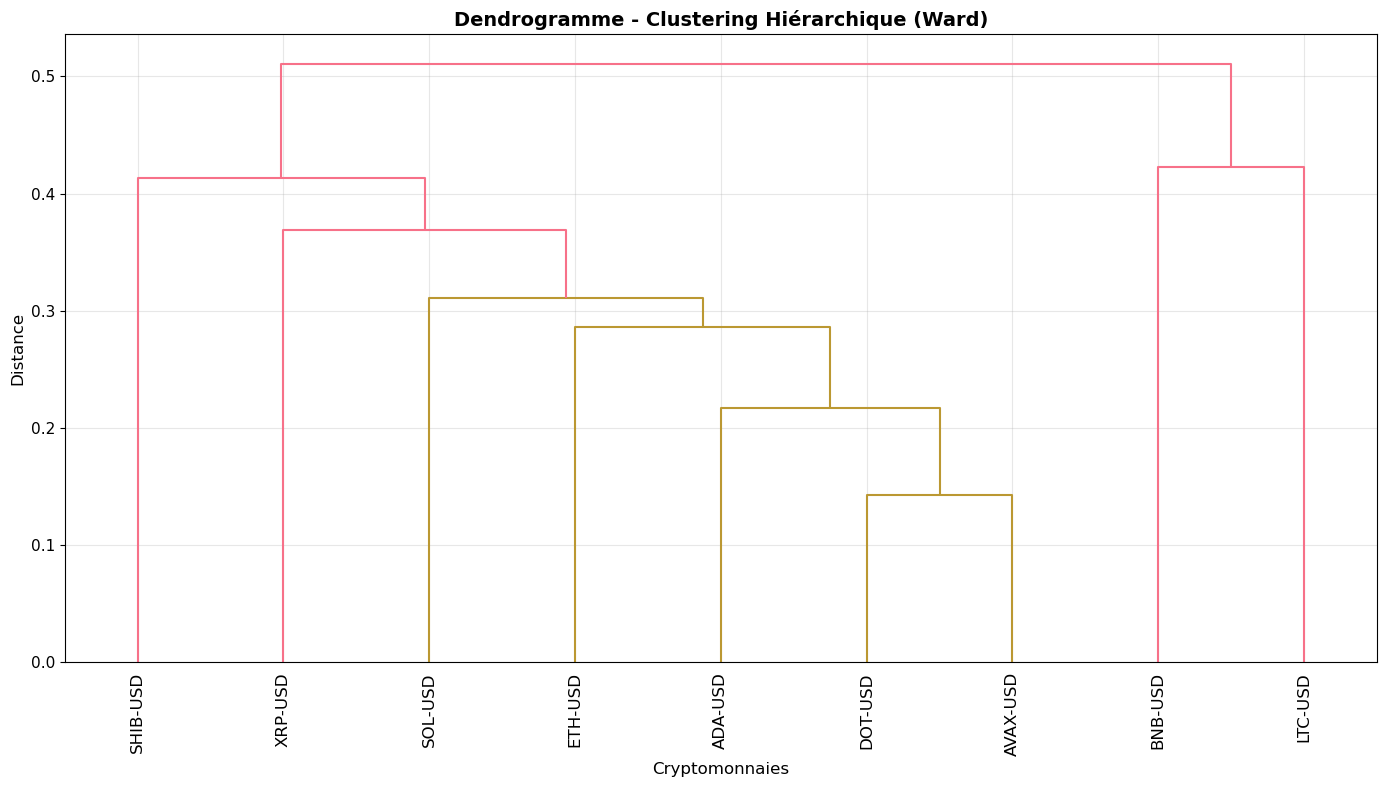


📊 Résultats du clustering (seuil: 1.5):
  Cluster 1: ETH-USD, BNB-USD, XRP-USD, SOL-USD, ADA-USD, DOT-USD, SHIB-USD, LTC-USD, AVAX-USD


In [12]:
def perform_hierarchical_clustering(correlation_matrix, method='ward', threshold=1.5):
    """
    Effectue un clustering hiérarchique sur la matrice de corrélation
    
    Args:
        correlation_matrix: Matrice de corrélation
        method: Méthode de linkage
        threshold: Seuil pour former les clusters
    
    Returns:
        Clusters, matrice de linkage, dictionnaire des clusters
    """
    print("🌳 Clustering hiérarchique en cours...")
    
    # Calcul de la matrice de distance adaptée (pour corrélations négatives)
    distance_matrix = np.sqrt(0.5 * (1 - correlation_matrix))
    
    # Conversion en matrice condensée pour linkage
    condensed_distances = squareform(distance_matrix)
    
    # Clustering hiérarchique
    linkage_matrix = linkage(condensed_distances, method=method)
    
    # Visualisation du dendrogramme
    plt.figure(figsize=(14, 8))
    dendrogram(linkage_matrix, 
               labels=correlation_matrix.columns, 
               leaf_rotation=90,
               leaf_font_size=12)
    plt.title(f"Dendrogramme - Clustering Hiérarchique ({method.title()})", 
              fontsize=14, fontweight='bold')
    plt.xlabel("Cryptomonnaies", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Attribution des clusters
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    # Affichage des résultats
    print(f"\n📊 Résultats du clustering (seuil: {threshold}):")
    cluster_dict = {}
    for crypto, cluster in zip(correlation_matrix.columns, clusters):
        if cluster not in cluster_dict:
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(crypto)
    
    for cluster_id, cryptos in cluster_dict.items():
        print(f"  Cluster {cluster_id}: {', '.join(cryptos)}")
    
    return clusters, linkage_matrix, cluster_dict

# Application du clustering hiérarchique
hierarchical_clusters, linkage_matrix, cluster_groups = perform_hierarchical_clustering(
    latest_correlation, method='ward', threshold=1.5
)

# 🕸️ 6. VISUALISATION EN RÉSEAU DES CORRÉLATIONS

Création d'un graphe pour visualiser les corrélations fortes entre cryptomonnaies (seuil > 0.6).
Cette représentation permet de mieux comprendre les relations entre les actifs.


🌐 VISUALISATION EN RÉSEAU DES CORRÉLATIONS

🕸️ Réseau de corrélations pour 2025-05-29:
🕸️ Création de la visualisation statique du réseau (seuil: 0.6)...
  33 connexions fortes détectées

📈 Statistiques du réseau:
  Nœuds: 9
  Arêtes: 33
  Densité: 0.917


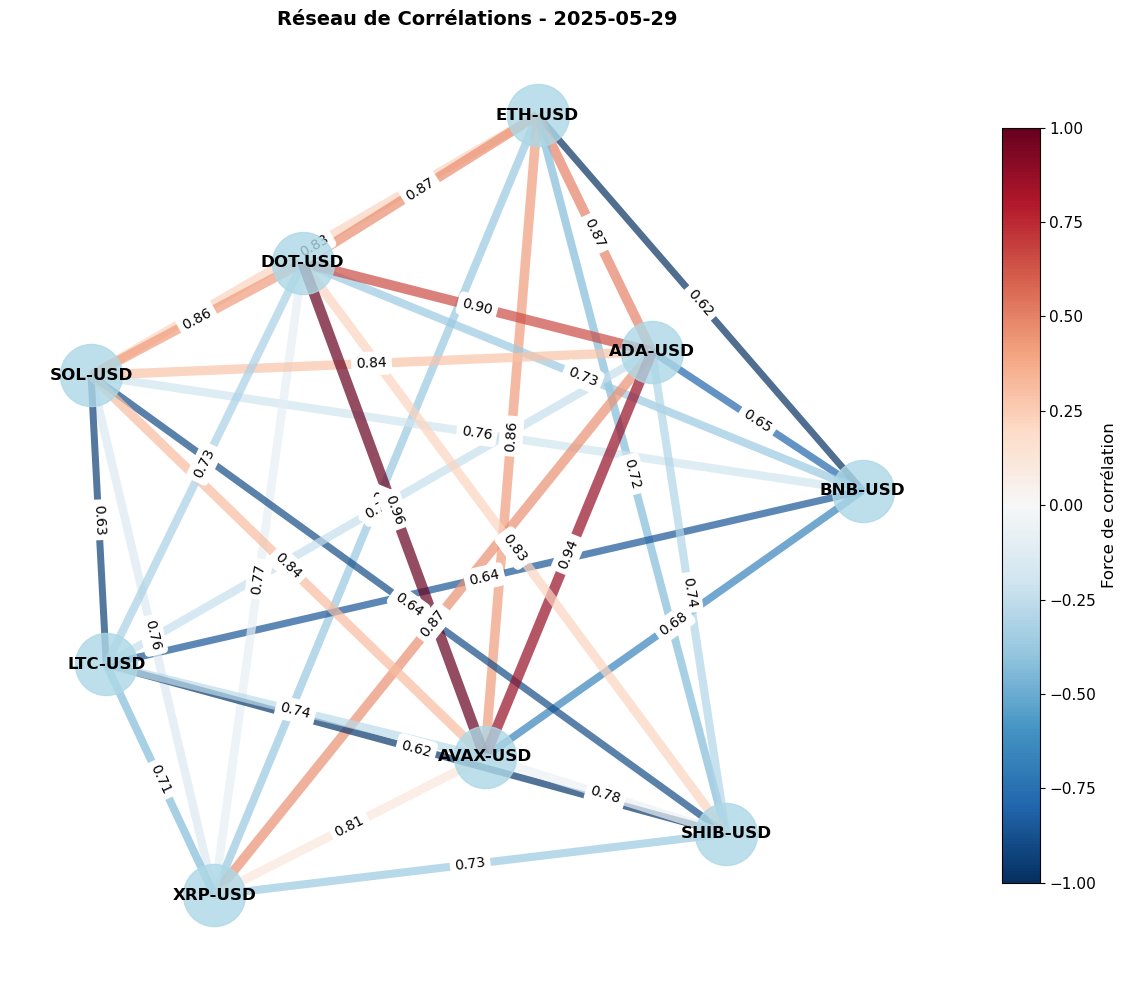


🔍 Visualisation des changements de régime détectés:
  Note: Variable 'regime_changes' non définie, utilisation de snapshots réguliers
🔄 Visualisation des changements de régime dans le réseau...
  Aucun changement de régime fourni, sélection de snapshots réguliers...


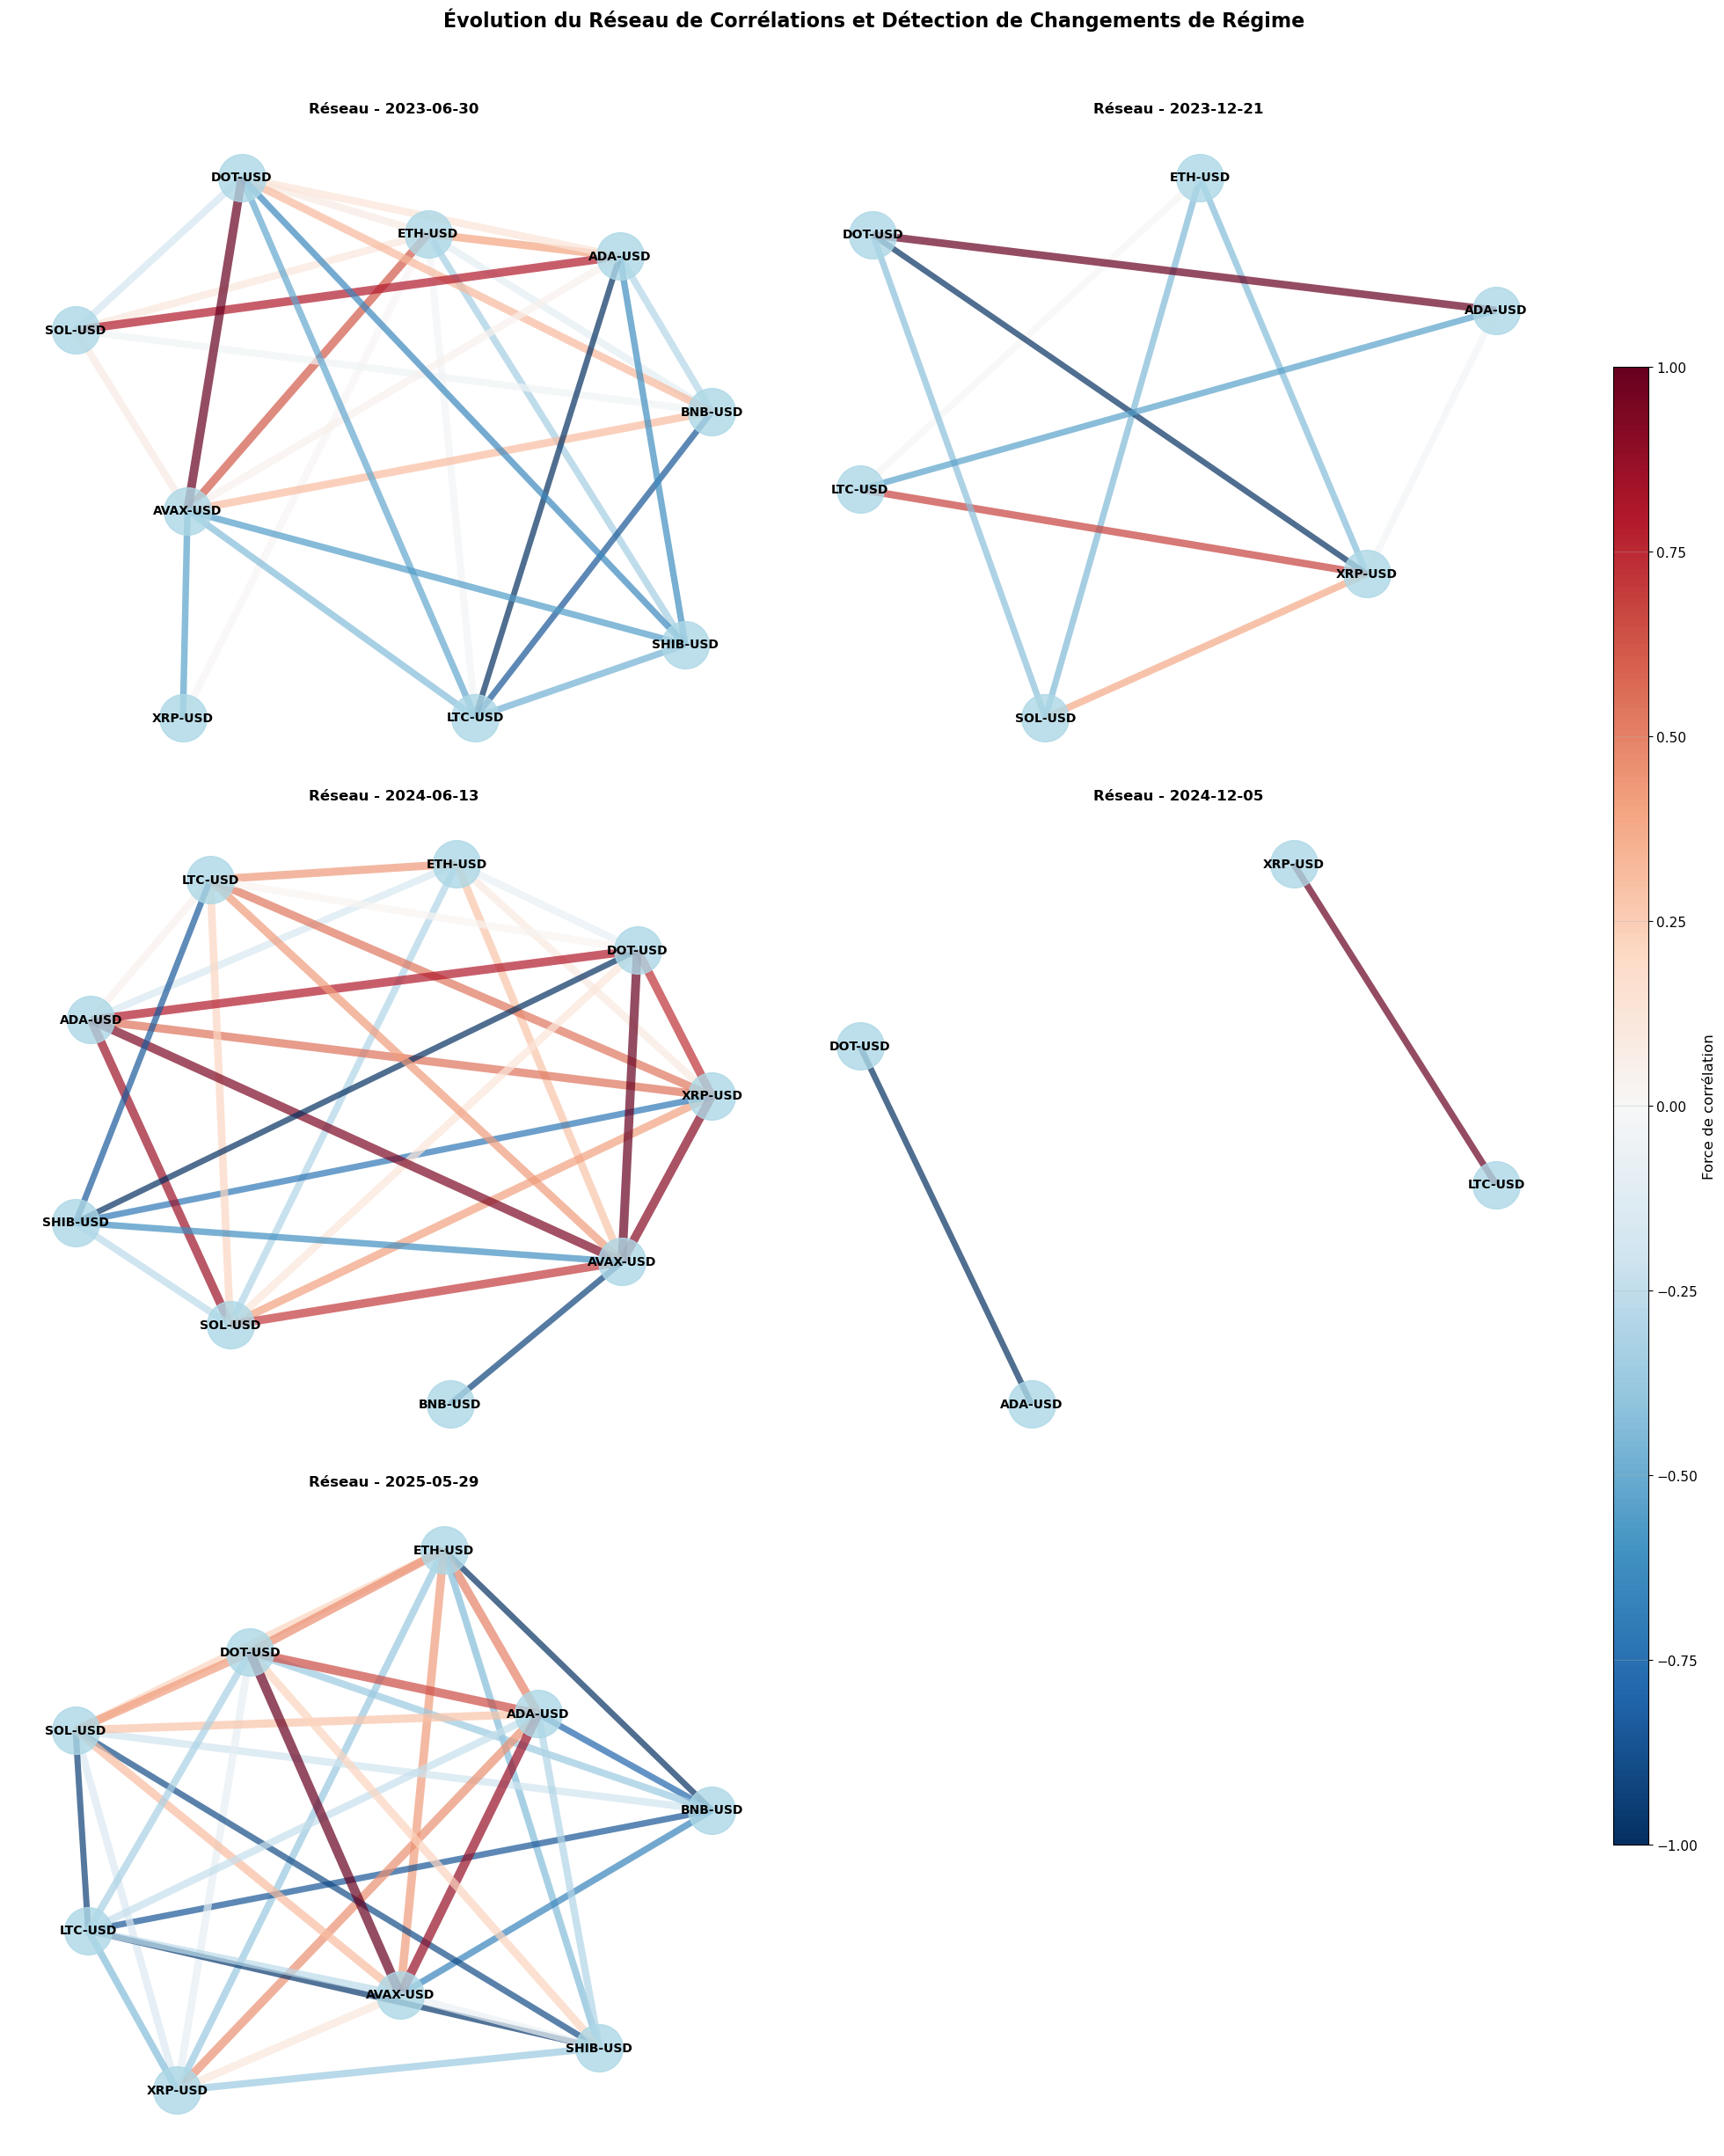


✅ Visualisation en réseau terminée


In [37]:
def create_static_network_visualization(correlation_matrix, title=None, threshold=0.6):
    """
    Crée une visualisation statique du réseau de corrélations
    
    Args:
        correlation_matrix: Matrice de corrélation
        title: Titre du graphique (optionnel)
        threshold: Seuil minimal de corrélation
    
    Returns:
        Figure matplotlib
    """
    print(f"🕸️ Création de la visualisation statique du réseau (seuil: {threshold})...")
    
    # Création du graphe
    G = nx.Graph()
    
    # Ajout des arêtes pour corrélations > seuil
    edges_added = 0
    for i, j in combinations(correlation_matrix.columns, 2):
        correlation_value = correlation_matrix.loc[i, j]
        if correlation_value > threshold:
            G.add_edge(i, j, weight=correlation_value)
            edges_added += 1
    
    print(f"  {edges_added} connexions fortes détectées")
    
    if edges_added == 0:
        print(f"  ⚠️ Aucune corrélation > {threshold} trouvée. Réduction du seuil...")
        threshold = 0.4
        for i, j in combinations(correlation_matrix.columns, 2):
            correlation_value = correlation_matrix.loc[i, j]
            if correlation_value > threshold:
                G.add_edge(i, j, weight=correlation_value)
                edges_added += 1
        print(f"  {edges_added} connexions détectées avec seuil réduit à {threshold}")
    
    # Calcul de la disposition
    pos = nx.spring_layout(G, seed=42, k=3, iterations=50)
    
    # Création d'une figure et d'un axe pour contrôler la colorbar
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Calcul des poids des arêtes pour la visualisation
    edge_weights = [G[u][v]['weight'] * 8 for u, v in G.edges()]
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Dessin du graphe
    nx.draw_networkx_nodes(G, pos, 
                          node_color='lightblue', 
                          node_size=2000, 
                          alpha=0.8,
                          ax=ax)
    
    edges = nx.draw_networkx_edges(G, pos, 
                                  width=edge_weights, 
                                  edge_color=edge_colors,
                                  edge_cmap=plt.cm.RdBu_r,
                                  alpha=0.7,
                                  ax=ax)
    
    nx.draw_networkx_labels(G, pos, 
                           font_size=12, 
                           font_weight='bold',
                           ax=ax)
    
    # Ajout des poids sur les arêtes
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10, ax=ax)
    
    # Création d'un ScalarMappable pour la colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=plt.Normalize(vmin=-1, vmax=1))
    sm.set_array([])
    
    # Ajout de la colorbar avec spécification de l'axe
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Force de corrélation', fontsize=12)
    
    # Titre du graphique
    if title:
        plt.title(title, fontsize=14, fontweight='bold')
    else:
        plt.title(f"Réseau des Corrélations Fortes (> {threshold})", 
                  fontsize=14, fontweight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    
    # Statistiques du réseau
    print(f"\n📈 Statistiques du réseau:")
    print(f"  Nœuds: {G.number_of_nodes()}")
    print(f"  Arêtes: {G.number_of_edges()}")
    print(f"  Densité: {nx.density(G):.3f}")
    
    return fig

def create_correlation_network_animation(rolling_correlations, dates, threshold=0.6, interval=200):
    """
    Crée une animation du réseau de corrélations dynamique
    
    Args:
        rolling_correlations: Liste de matrices de corrélation
        dates: Liste des dates correspondantes
        threshold: Seuil de corrélation pour créer une arête
        interval: Intervalle entre les frames (ms)
    
    Returns:
        Animation matplotlib
    """
    print(f"🎬 Création de l'animation du réseau (seuil: {threshold})...")
    
    # Configuration de la figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Fonction pour créer le graphe à partir d'une matrice
    def create_graph(correlation_matrix):
        G = nx.Graph()
        # Ajouter les nœuds
        for crypto in correlation_matrix.columns:
            G.add_node(crypto)
        # Ajouter les arêtes pour les corrélations > seuil
        for i, j in combinations(correlation_matrix.columns, 2):
            correlation_value = correlation_matrix.loc[i, j]
            if correlation_value > threshold:
                G.add_edge(i, j, weight=correlation_value)
        return G
    
    # Création des graphes pour chaque période
    print("  Préparation des graphes...")
    graphs = []
    for i, corr_matrix in enumerate(rolling_correlations):
        if i % 50 == 0:
            progress = (i / len(rolling_correlations)) * 100
            print(f"    Progression: {progress:.1f}%")
        graphs.append(create_graph(corr_matrix))
    
    # Calcul du layout stable entre les frames (moyenne des positions)
    print("  Calcul de la disposition stable...")
    pos_dict = {}
    for G in graphs:
        pos = nx.spring_layout(G, k=3, iterations=50)
        for node, position in pos.items():
            if node not in pos_dict:
                pos_dict[node] = []
            pos_dict[node].append(position)
    
    # Position moyenne pour chaque nœud
    avg_pos = {}
    for node, positions in pos_dict.items():
        avg_pos[node] = np.mean(positions, axis=0)
    
    # Fonction pour mettre à jour l'animation
    def update(frame):
        ax.clear()
        G = graphs[frame]
        
        # Calcul des poids des arêtes pour la visualisation
        edge_weights = [G[u][v]['weight'] * 8 for u, v in G.edges()]
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Dessin du graphe
        nx.draw_networkx_nodes(G, avg_pos, 
                              node_color='lightblue', 
                              node_size=2000, 
                              alpha=0.8,
                              ax=ax)
        
        edges = nx.draw_networkx_edges(G, avg_pos, 
                                      width=edge_weights, 
                                      edge_color=edge_colors,
                                      edge_cmap=plt.cm.RdBu_r,
                                      alpha=0.7,
                                      ax=ax)
        
        nx.draw_networkx_labels(G, avg_pos, 
                               font_size=12, 
                               font_weight='bold',
                               ax=ax)
        
        ax.set_title(f"Réseau de Corrélations - {dates[frame].date()}", 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
        
        return edges,
    
    # Création de l'animation
    print("  Création de l'animation...")
    anim = animation.FuncAnimation(fig, update, frames=len(graphs), 
                                  interval=interval, blit=False)
    
    # Ajout de la colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=plt.Normalize(vmin=-1, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Force de corrélation', fontsize=12)
    
    plt.tight_layout()
    print("✅ Animation créée avec succès!")
    
    return anim

def visualize_regime_shifts_network(rolling_correlations, dates, regime_changes=None, n_snapshots=5):
    """
    Visualise le réseau de corrélations à des moments clés ou lors des changements de régime
    
    Args:
        rolling_correlations: Liste des matrices de corrélation
        dates: Dates correspondantes
        regime_changes: Indices des changements de régime (optionnel)
        n_snapshots: Nombre de snapshots à afficher si pas de changements de régime
    """
    print("🔄 Visualisation des changements de régime dans le réseau...")
    
    # Si pas de changements de régime fournis, prendre des snapshots réguliers
    if regime_changes is None or len(regime_changes) == 0:
        print("  Aucun changement de régime fourni, sélection de snapshots réguliers...")
        indices = np.linspace(0, len(rolling_correlations)-1, n_snapshots, dtype=int)
    else:
        indices = regime_changes
        print(f"  Visualisation de {len(indices)} changements de régime détectés")
    
    # Création d'une grille de subplots
    n_rows = (len(indices) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(20, 8*n_rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= len(axes):  # S'assurer qu'on ne dépasse pas le nombre d'axes
            break
            
        corr_matrix = rolling_correlations[idx]
        date = dates[idx]
        
        # Création du graphe
        G = nx.Graph()
        edges_added = 0
        threshold = 0.6  # Seuil initial
        
        for j, k in combinations(corr_matrix.columns, 2):
            correlation_value = corr_matrix.loc[j, k]
            if correlation_value > threshold:
                G.add_edge(j, k, weight=correlation_value)
                edges_added += 1
        
        # Réduire le seuil si nécessaire
        if edges_added == 0:
            threshold = 0.4
            for j, k in combinations(corr_matrix.columns, 2):
                correlation_value = corr_matrix.loc[j, k]
                if correlation_value > threshold:
                    G.add_edge(j, k, weight=correlation_value)
                    edges_added += 1
        
        # Position des nœuds
        pos = nx.spring_layout(G, seed=42, k=3, iterations=50)
        
        # Calcul des poids des arêtes
        edge_weights = [G[u][v]['weight'] * 8 for u, v in G.edges()]
        edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Dessin du graphe
        nx.draw_networkx_nodes(G, pos, 
                              node_color='lightblue', 
                              node_size=1500, 
                              alpha=0.8,
                              ax=axes[i])
        
        nx.draw_networkx_edges(G, pos, 
                              width=edge_weights, 
                              edge_color=edge_colors,
                              edge_cmap=plt.cm.RdBu_r,
                              alpha=0.7,
                              ax=axes[i])
        
        nx.draw_networkx_labels(G, pos, 
                               font_size=10, 
                               font_weight='bold',
                               ax=axes[i])
        
        # Titre du subplot
        change_text = " (Changement de Régime!)" if regime_changes is not None else ""
        axes[i].set_title(f"Réseau - {date.date()}{change_text}", 
                       fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    # Masquer les axes inutilisés
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Colorbar commune
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=plt.Normalize(vmin=-1, vmax=1))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Force de corrélation', fontsize=12)
    
    plt.suptitle("Évolution du Réseau de Corrélations et Détection de Changements de Régime", 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Application des visualisations
print("\n" + "="*50)
print("🌐 VISUALISATION EN RÉSEAU DES CORRÉLATIONS")
print("="*50)

# 1. Visualisation statique du réseau le plus récent
# S'assurer que latest_correlation est défini
if 'latest_correlation' not in locals() or 'latest_correlation' not in globals():
    latest_correlation = rolling_correlations[-1]

latest_date = correlation_dates[-1]
print(f"\n🕸️ Réseau de corrélations pour {latest_date.strftime('%Y-%m-%d')}:")
network_graph = create_static_network_visualization(
    latest_correlation, 
    title=f"Réseau de Corrélations - {latest_date.strftime('%Y-%m-%d')}"
)
plt.show()

# 2. Visualisation des changements de régime
print("\n🔍 Visualisation des changements de régime détectés:")
# Vérifier si regime_changes est défini
if 'regime_changes' not in locals() or 'regime_changes' not in globals():
    print("  Note: Variable 'regime_changes' non définie, utilisation de snapshots réguliers")
    # Passer None à la fonction, qui utilisera des snapshots réguliers automatiquement
    visualize_regime_shifts_network(rolling_correlations, correlation_dates, None)
else:
    visualize_regime_shifts_network(rolling_correlations, correlation_dates, regime_changes)

# 3. Animation de l'évolution du réseau (optionnelle - décommenter pour exécuter)
# print("\n🎬 Création de l'animation du réseau (peut prendre du temps):")
# subset_indices = np.linspace(0, len(rolling_correlations)-1, 50, dtype=int)  # Réduire pour performance
# network_anim = create_correlation_network_animation(
#     [rolling_correlations[i] for i in subset_indices], 
#     [correlation_dates[i] for i in subset_indices],
#     threshold=0.5, 
#     interval=300
# )
# plt.show()

print("\n✅ Visualisation en réseau terminée")

# ⏰ 7. CLUSTERING TEMPOREL AVEC K-MEANS

Application de K-Means sur les matrices de corrélation aplaties pour identifier des régimes 
temporels distincts dans les relations entre cryptomonnaies.

⏰ Clustering temporel K-Means (3 clusters)...
  Données préparées: (700, 72)
  Répartition des clusters:
    Cluster 1: 156 jours (22.3%)
    Cluster 2: 391 jours (55.9%)
    Cluster 3: 153 jours (21.9%)


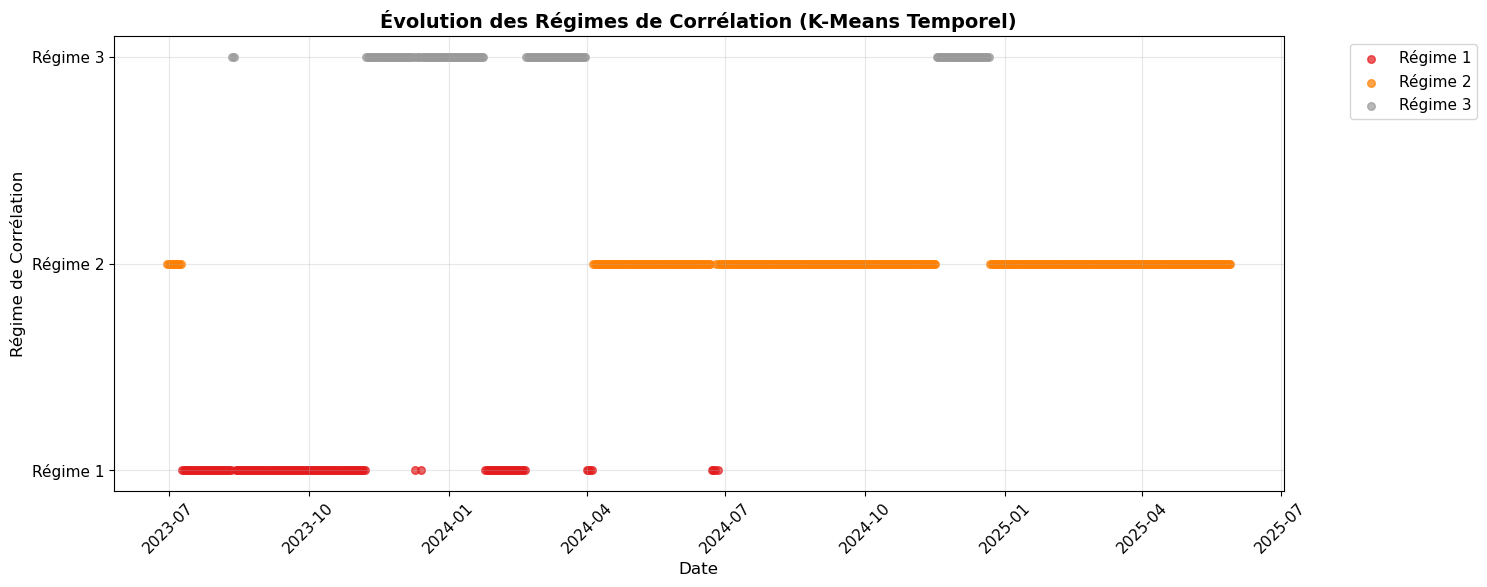

In [16]:
def perform_temporal_kmeans_clustering(rolling_correlations, n_clusters=3):
    """
    Effectue un clustering K-Means temporel sur les matrices de corrélation
    
    Args:
        rolling_correlations: Liste des matrices de corrélation
        n_clusters: Nombre de clusters
    
    Returns:
        Labels des clusters, modèle K-Means, données aplaties
    """
    print(f"⏰ Clustering temporel K-Means ({n_clusters} clusters)...")
    
    # Fonction pour aplatir la matrice de corrélation (sans diagonale)
    def flatten_correlation_matrix(correlation_matrix):
        mask = ~np.eye(correlation_matrix.shape[0], dtype=bool)
        return correlation_matrix.values[mask]
    
    # Aplatissement de toutes les matrices
    flattened_data = np.array([
        flatten_correlation_matrix(corr_matrix) 
        for corr_matrix in rolling_correlations
    ])
    
    print(f"  Données préparées: {flattened_data.shape}")
    
    # Application du K-Means
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans_model.fit_predict(flattened_data)
    
    # Calcul des statistiques
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    print(f"  Répartition des clusters:")
    for label, count in zip(unique_labels, counts):
        percentage = count / len(cluster_labels) * 100
        print(f"    Cluster {label+1}: {count} jours ({percentage:.1f}%)")
    
    return cluster_labels, kmeans_model, flattened_data

def visualize_temporal_clusters(dates, cluster_labels, n_clusters=3):
    """
    Visualise l'évolution temporelle des clusters
    
    Args:
        dates: Dates correspondantes
        cluster_labels: Labels des clusters
        n_clusters: Nombre de clusters
    """
    plt.figure(figsize=(15, 6))
    
    # Couleurs pour chaque cluster
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    # Graphique principal
    for i in range(n_clusters):
        mask = cluster_labels == i
        plt.scatter(dates[mask], cluster_labels[mask] + 1, 
                   c=[colors[i]], label=f'Régime {i+1}', 
                   alpha=0.7, s=30)
    
    plt.ylabel("Régime de Corrélation", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.title("Évolution des Régimes de Corrélation (K-Means Temporel)", 
              fontsize=14, fontweight='bold')
    plt.yticks(range(1, n_clusters+1), [f'Régime {i+1}' for i in range(n_clusters)])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Application du clustering temporel
temporal_labels, kmeans_model, correlation_data = perform_temporal_kmeans_clustering(
    rolling_correlations, n_clusters=3
)

# Visualisation
visualize_temporal_clusters(correlation_dates, temporal_labels, n_clusters=3)

# 🔍 8. DÉTECTION AUTOMATIQUE DES CHANGEMENTS DE RÉGIME

Utilisation de l'analyse de variance et de la détection de pics pour identifier 
automatiquement les périodes de changement structurel dans les corrélations.

🔍 Détection automatique des changements de régime...


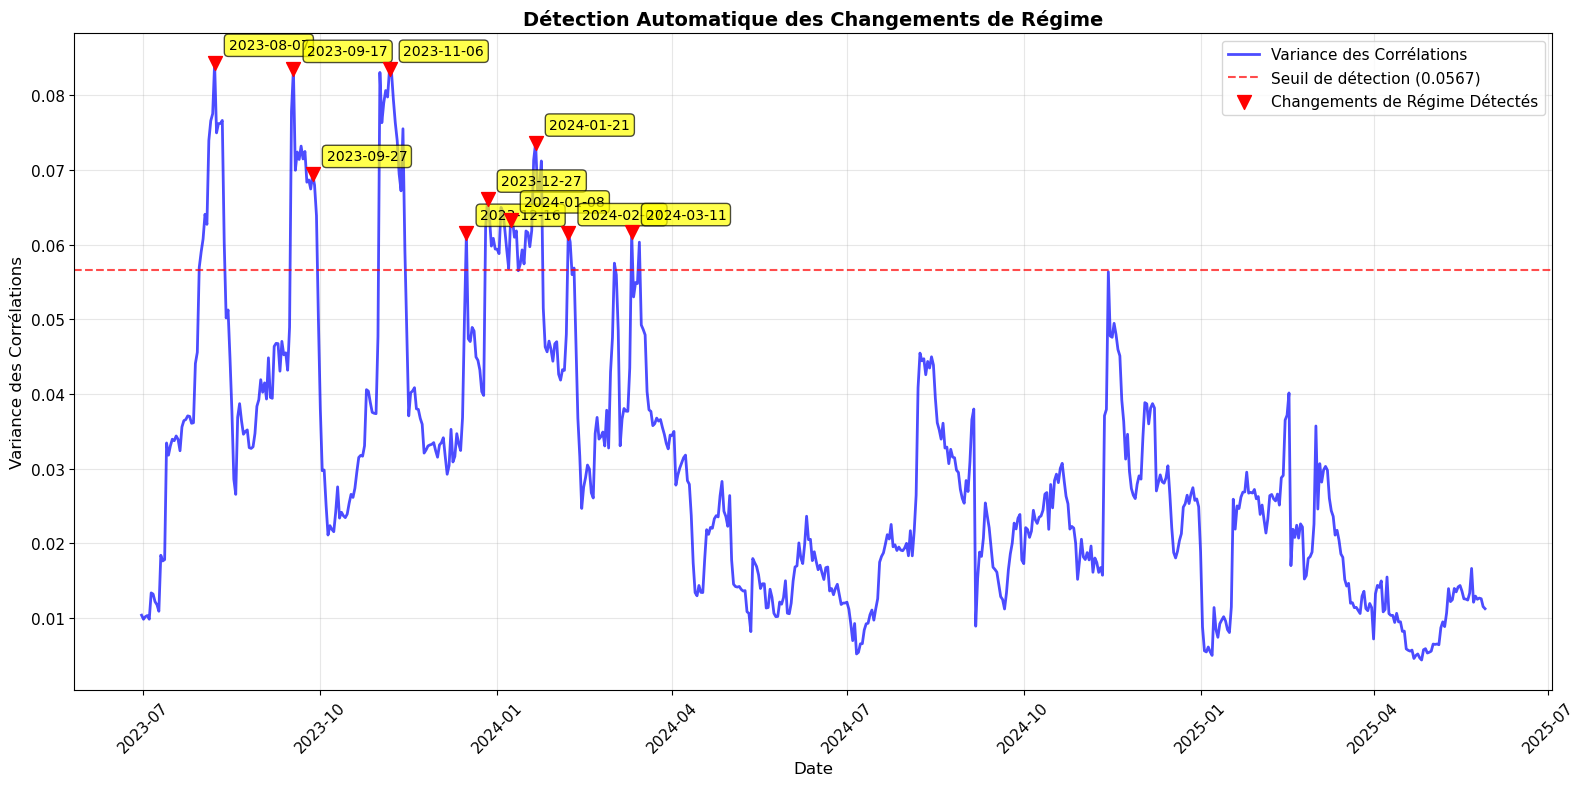


📊 Résultats de la détection:
  Changements de régime détectés: 10
  Variance moyenne: 0.0300
  Variance maximale: 0.0843

📅 Dates des changements détectés:
    2023-08-07 (variance: 0.0843)
    2023-09-17 (variance: 0.0835)
    2023-09-27 (variance: 0.0694)
    2023-11-06 (variance: 0.0835)
    2023-12-16 (variance: 0.0616)
    2023-12-27 (variance: 0.0661)
    2024-01-08 (variance: 0.0633)
    2024-01-21 (variance: 0.0736)
    2024-02-07 (variance: 0.0616)
    2024-03-11 (variance: 0.0616)


In [18]:
def detect_regime_changes(rolling_correlations, dates):
    """
    Détecte automatiquement les changements de régime basés sur la variance des corrélations
    
    Args:
        rolling_correlations: Liste des matrices de corrélation
        dates: Dates correspondantes
    
    Returns:
        Indices des changements de régime, variance temporelle
    """
    print("🔍 Détection automatique des changements de régime...")
    
    # Calcul de la variance moyenne des corrélations dans le temps
    variance_timeline = []
    
    for correlation_matrix in rolling_correlations:
        # Extraction de la partie supérieure de la matrice (sans diagonale)
        upper_triangle = correlation_matrix.where(
            np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        )
        variance = np.nanvar(upper_triangle.values.flatten())
        variance_timeline.append(variance)
    
    variance_timeline = np.array(variance_timeline)
    
    # Détection des pics de variance (changements de régime potentiels)
    threshold_height = np.mean(variance_timeline) + 1.5 * np.std(variance_timeline)
    regime_change_indices, properties = find_peaks(
        variance_timeline, 
        height=threshold_height,
        distance=10  # Distance minimale entre pics
    )
    
    # Visualisation
    plt.figure(figsize=(16, 8))
    
    # Graphique principal
    plt.plot(dates, variance_timeline, 
             label='Variance des Corrélations', 
             linewidth=2, color='blue', alpha=0.7)
    
    # Ligne de seuil
    plt.axhline(y=threshold_height, color='red', linestyle='--', 
                label=f'Seuil de détection ({threshold_height:.4f})', alpha=0.7)
    
    # Points de changement de régime
    if len(regime_change_indices) > 0:
        plt.scatter(dates[regime_change_indices], 
                   variance_timeline[regime_change_indices],
                   color='red', s=100, marker='v', 
                   label='Changements de Régime Détectés', 
                   zorder=5)
        
        # Annotations
        for idx in regime_change_indices:
            plt.annotate(f'{dates[idx].strftime("%Y-%m-%d")}',
                        (dates[idx], variance_timeline[idx]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.7),
                        fontsize=10)
    
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Variance des Corrélations', fontsize=12)
    plt.title('Détection Automatique des Changements de Régime', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print(f"\n📊 Résultats de la détection:")
    print(f"  Changements de régime détectés: {len(regime_change_indices)}")
    print(f"  Variance moyenne: {np.mean(variance_timeline):.4f}")
    print(f"  Variance maximale: {np.max(variance_timeline):.4f}")
    
    if len(regime_change_indices) > 0:
        print(f"\n📅 Dates des changements détectés:")
        for idx in regime_change_indices:
            date_str = dates[idx].strftime("%Y-%m-%d")
            variance_val = variance_timeline[idx]
            print(f"    {date_str} (variance: {variance_val:.4f})")
    else:
        print(f"  ℹ️ Aucun changement de régime significatif détecté")
    
    return regime_change_indices, variance_timeline

# Détection des changements de régime
regime_changes, variance_data = detect_regime_changes(rolling_correlations, correlation_dates)

# 🌟 9. CLUSTERING SPECTRAL OPTIMISÉ

Application du clustering spectral avec optimisation du nombre de clusters par analyse du score silhouette.
Cette méthode est particulièrement adaptée aux données non-convexes et aux structures complexes.

🌟 Clustering spectral avec optimisation...
  2 clusters → Score silhouette: 0.240
  3 clusters → Score silhouette: 0.258
  4 clusters → Score silhouette: 0.037
  5 clusters → Score silhouette: 0.197
  6 clusters → Score silhouette: 0.049


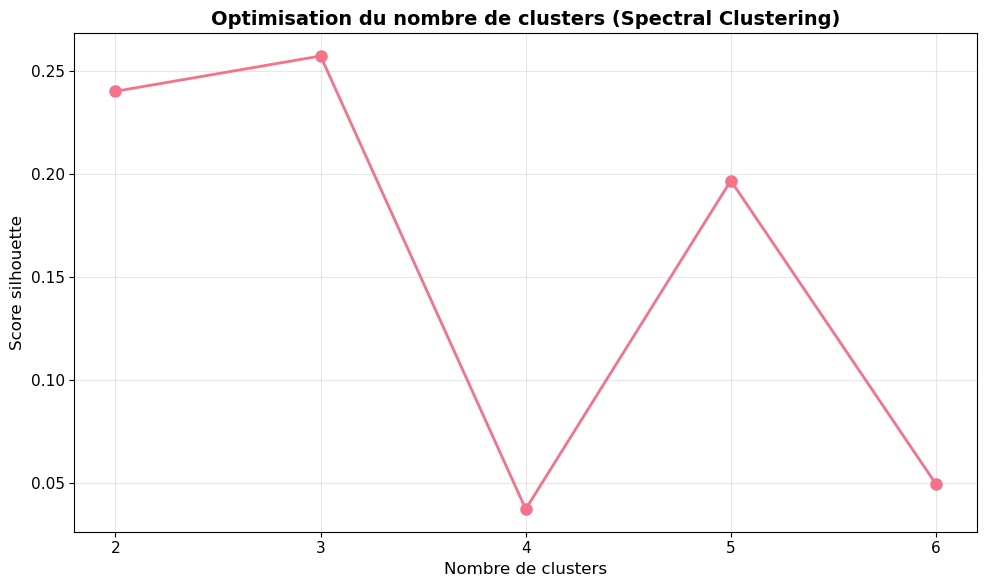


🎯 Nombre optimal de clusters: 3 (score: 0.258)
  Groupe 1: ETH-USD, XRP-USD, ADA-USD, DOT-USD, SHIB-USD, AVAX-USD
  Groupe 2: BNB-USD, SOL-USD
  Groupe 3: LTC-USD


In [26]:
def perform_spectral_clustering(correlation_matrix, max_clusters=6):
    """
    Effectue un clustering spectral optimisé sur la matrice de corrélation

    Args:
        correlation_matrix: Matrice de corrélation
        max_clusters: Nombre maximum de clusters à tester

    Returns:
        Labels des clusters, nombre optimal de clusters, scores silhouette, groupes
    """
    print("🌟 Clustering spectral avec optimisation...")

    # Conversion en matrice de similarité normalisée entre 0 et 1
    similarity_matrix = (correlation_matrix + 1) / 2

    # Conversion en matrice de distances et mise à 0 de la diagonale
    distance_matrix = 1 - similarity_matrix
    np.fill_diagonal(distance_matrix.values, 0)

    n_clusters_range = range(2, min(max_clusters + 1, len(correlation_matrix.columns)))
    silhouette_scores = []
    all_labels = []

    for n_clusters in n_clusters_range:
        spectral = SpectralClustering(
            n_clusters=n_clusters,
            affinity='precomputed',
            random_state=42
        )
        labels = spectral.fit_predict(similarity_matrix)
        score = silhouette_score(distance_matrix, labels, metric='precomputed')
        silhouette_scores.append(score)
        all_labels.append(labels)

        print(f"  {n_clusters} clusters → Score silhouette: {score:.3f}")

    # Visualisation des scores
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Nombre de clusters', fontsize=12)
    plt.ylabel('Score silhouette', fontsize=12)
    plt.title('Optimisation du nombre de clusters (Spectral Clustering)',
              fontsize=14, fontweight='bold')
    plt.xticks(list(n_clusters_range))
    plt.tight_layout()
    plt.show()

    # Sélection du meilleur clustering
    best_idx = np.argmax(silhouette_scores)
    optimal_n_clusters = list(n_clusters_range)[best_idx]
    optimal_labels = all_labels[best_idx]

    print(f"\n🎯 Nombre optimal de clusters: {optimal_n_clusters} (score: {silhouette_scores[best_idx]:.3f})")

    # Regroupement par cluster
    spectral_groups = {}
    for i, crypto in enumerate(correlation_matrix.columns):
        cluster_id = optimal_labels[i]
        if cluster_id not in spectral_groups:
            spectral_groups[cluster_id] = []
        spectral_groups[cluster_id].append(crypto)

    for cluster_id, cryptos in spectral_groups.items():
        print(f"  Groupe {cluster_id + 1}: {', '.join(cryptos)}")

    return optimal_labels, optimal_n_clusters, silhouette_scores, spectral_groups
    
    # Visualisation des scores
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Nombre de clusters', fontsize=12)
    plt.ylabel('Score silhouette', fontsize=12)
    plt.title('Optimisation du nombre de clusters (Spectral Clustering)', 
              fontsize=14, fontweight='bold')
    plt.xticks(list(n_clusters_range))
    plt.tight_layout()
    plt.show()
    
    # Sélection du meilleur nombre de clusters
    best_idx = np.argmax(silhouette_scores)
    optimal_n_clusters = list(n_clusters_range)[best_idx]
    optimal_labels = all_labels[best_idx]
    
    # Affichage des résultats
    print(f"\n🎯 Nombre optimal de clusters: {optimal_n_clusters} (score: {silhouette_scores[best_idx]:.3f})")
    
    # Organisation des résultats par groupe
    spectral_groups = {}
    for i, crypto in enumerate(correlation_matrix.columns):
        cluster_id = optimal_labels[i]
        if cluster_id not in spectral_groups:
            spectral_groups[cluster_id] = []
        spectral_groups[cluster_id].append(crypto)
    
    for cluster_id, cryptos in spectral_groups.items():
        print(f"  Groupe {cluster_id + 1}: {', '.join(cryptos)}")
    
    return optimal_labels, optimal_n_clusters, silhouette_scores, spectral_groups

# Application du clustering spectral optimisé
spectral_labels, optimal_n_clusters, silhouette_scores, spectral_groups = perform_spectral_clustering(
    latest_correlation, max_clusters=6
)

# 📋 10. RAPPORT FINAL ET CONCLUSION

Synthèse des analyses effectuées et des résultats obtenus.

In [28]:
def generate_final_report():
    """
    Génère un rapport final avec tous les résultats de l'analyse
    """
    print("\n" + "="*65)
    print("📋 RAPPORT FINAL - ANALYSE DE CORRÉLATION DES CRYPTOMONNAIES")
    print("="*65)
    
    # 1. Résumé des données
    print(f"\n📊 DONNÉES ANALYSÉES:")
    print(f"  • Cryptomonnaies: {len(crypto_symbols)}")
    print(f"  • Période d'analyse: {correlation_dates[0].date()} à {correlation_dates[-1].date()}")
    print(f"  • Nombre de jours: {len(data_close)}")
    print(f"  • Matrices de corrélation calculées: {len(rolling_correlations)}")
    
    # 2. Résultats du clustering hiérarchique
    print(f"\n🌳 CLUSTERING HIÉRARCHIQUE:")
    for cluster_id, cryptos in cluster_groups.items():
        print(f"    Groupe {cluster_id}: {', '.join(cryptos)}")
    
    # 3. Résultats du clustering spectral
    print(f"\n🌟 CLUSTERING SPECTRAL OPTIMAL ({optimal_n_clusters} clusters):")
    for cluster_id, cryptos in spectral_groups.items():
        print(f"    Groupe {cluster_id + 1}: {', '.join(cryptos)}")
    
    # 4. Changements de régime
    print(f"\n🔍 DÉTECTION DE RÉGIMES:")
    print(f"  • Changements de régime détectés: {len(regime_changes)}")
    if len(regime_changes) > 0:
        for idx in regime_changes:
            print(f"    - {correlation_dates[idx].strftime('%Y-%m-%d')}")
    
    # 5. Statistiques temporelles
    temporal_counts = np.bincount(temporal_labels)
    print(f"\n⏰ RÉGIMES TEMPORELS (K-Means):")
    for i, count in enumerate(temporal_counts):
        percentage = count / len(temporal_labels) * 100
        print(f"    Régime {i+1}: {count} jours ({percentage:.1f}%)")
    
    # 6. Métriques de qualité
    correlation_mean = latest_correlation.mean().mean()
    correlation_std = np.std([corr.mean().mean() for corr in rolling_correlations])
    
    print(f"\n📊 MÉTRIQUES DE QUALITÉ:")
    print(f"  • Corrélation moyenne actuelle: {correlation_mean:.3f}")
    print(f"  • Volatilité des corrélations: {correlation_std:.3f}")
    print(f"  • Score silhouette spectral: {silhouette_scores[optimal_n_clusters-2]:.3f}")
    
    # 7. Recommandations
    print(f"\n💡 RECOMMANDATIONS:")
    print(f"  • Diversification: Investir dans différents clusters pour réduire le risque")
    print(f"  • Surveillance: Monitorer les changements de régime pour ajuster la stratégie")
    print(f"  • Gestion des risques: Vigilance accrue en période de forte corrélation")
    
    print(f"\n✅ ANALYSE TERMINÉE AVEC SUCCÈS")
    print("="*65)

# Sauvegarde des résultats
def save_all_results():
    """
    Sauvegarde tous les résultats dans des fichiers CSV
    """
    print("\n💾 Sauvegarde des résultats finaux...")
    
    try:
        # 1. Rendements logarithmiques
        log_returns.to_csv('log_returns_final.csv')
        print("  ✅ log_returns_final.csv")
        
        # 2. Résultats du clustering
        clustering_results = pd.DataFrame({
            'cryptocurrency': latest_correlation.columns,
            'hierarchical_cluster': hierarchical_clusters,
            'spectral_cluster': spectral_labels + 1,  # +1 pour commencer à 1
            'temporal_cluster_final': temporal_labels[-1] + 1
        })
        clustering_results.to_csv('clustering_results_final.csv', index=False)
        print("  ✅ clustering_results_final.csv")
        
        # 3. Détection de régimes
        regime_data = pd.DataFrame({
            'date': correlation_dates,
            'variance': variance_data,
            'temporal_cluster': temporal_labels + 1
        })
        regime_data.to_csv('regime_detection_results.csv', index=False)
        print("  ✅ regime_detection_results.csv")
        
        print(f"\n🎯 Tous les fichiers sauvegardés avec succès!")
        
    except Exception as e:
        print(f"  ❌ Erreur lors de la sauvegarde: {e}")

# Génération du rapport final
generate_final_report()

# Sauvegarde des résultats
save_all_results()


📋 RAPPORT FINAL - ANALYSE DE CORRÉLATION DES CRYPTOMONNAIES

📊 DONNÉES ANALYSÉES:
  • Cryptomonnaies: 9
  • Période d'analyse: 2023-06-30 à 2025-05-29
  • Nombre de jours: 730
  • Matrices de corrélation calculées: 700

🌳 CLUSTERING HIÉRARCHIQUE:
    Groupe 1: ETH-USD, BNB-USD, XRP-USD, SOL-USD, ADA-USD, DOT-USD, SHIB-USD, LTC-USD, AVAX-USD

🌟 CLUSTERING SPECTRAL OPTIMAL (3 clusters):
    Groupe 1: ETH-USD, XRP-USD, ADA-USD, DOT-USD, SHIB-USD, AVAX-USD
    Groupe 2: BNB-USD, SOL-USD
    Groupe 3: LTC-USD

🔍 DÉTECTION DE RÉGIMES:
  • Changements de régime détectés: 10
    - 2023-08-07
    - 2023-09-17
    - 2023-09-27
    - 2023-11-06
    - 2023-12-16
    - 2023-12-27
    - 2024-01-08
    - 2024-01-21
    - 2024-02-07
    - 2024-03-11

⏰ RÉGIMES TEMPORELS (K-Means):
    Régime 1: 156 jours (22.3%)
    Régime 2: 391 jours (55.9%)
    Régime 3: 153 jours (21.9%)

📊 MÉTRIQUES DE QUALITÉ:
  • Corrélation moyenne actuelle: 0.779
  • Volatilité des corrélations: 0.100
  • Score silhouette sp

# 💡 CONCLUSION ET RECOMMANDATIONS

## 🎯 Principaux Résultats

L'analyse de corrélation dynamique des cryptomonnaies a révélé plusieurs insights importants :

1. **Groupes de Cryptomonnaies** : Le clustering a identifié des groupes distincts avec des comportements corrélés
2. **Évolution Temporelle** : Les corrélations ne sont pas statiques et évoluent significativement 
3. **Changements de Régime** : Des périodes distinctes avec des structures de corrélation différentes
4. **Diversification** : Possibilités d'optimisation de portefeuille basées sur les groupes identifiés

## 💼 Recommandations pour les Investisseurs

- **Diversification** : Répartir les investissements entre différents clusters
- **Surveillance** : Monitorer les changements de régime pour ajuster la stratégie
- **Gestion des Risques** : Être vigilant pendant les périodes de forte corrélation
- **Opportunités** : Exploiter les décorrélations temporaires pour des stratégies de trading

**Projet réalisé dans le cadre de l'analyse de données financières - Data Mining**

*Date de finalisation : Mai 2025*